In [103]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd; pd.set_option('precision', 10)
import numpy as np; np.set_printoptions(precision=4, suppress=True)
from scipy import stats

import scipy.optimize as opt

import datetime as dt

import matplotlib.pyplot as plt
import pickle

In [104]:
start_train = '1999-12-31'
end_train = '2015-01-01'
start_test = '2015-01-02'
end_test = '2020-05-19'

import os 
cwd = os.getcwd()
print(os.getcwd())
os.chdir('/home/math/PycharmProjects/hmm-master')

/home/math/PycharmProjects/hmm-master


In [105]:
df = pd.read_csv('data/price_series.csv', index_col = 'Time')

df.index = pd.to_datetime(df.index)

In [106]:
df.dropna(inplace=True)

print(len(df))

4173


In [107]:
## Create Fake States (Here we should incorporate the predicted states from Viterbi)

nums = np.ones(4173)
nums[:1500] = 0
np.random.shuffle(nums)

df['states'] = nums

In [108]:
first_asset = "Hedge Funds Global"
last_asset = "Private Equity"

####### Index all factors to 100 starting at the same time
df.loc[:,first_asset:last_asset] = df.loc[:,first_asset:last_asset] / df.iloc[0][first_asset:last_asset] * 100


#### Recompute RF as daily returns
df["T-bills rf"] = df["T-bills rf"].pct_change() 



In [109]:
####### Compute returns for all factors and store it in a new dataframe
df_ret = df.copy()
df_ret.loc[:, first_asset:last_asset] = df_ret.loc[:,first_asset:last_asset].pct_change() #Actual return
df_ret.dropna(inplace=True)


# Take only train period for Mean-Var optimization
df_excess = df_ret.loc[start_train:end_train]
df_excess.loc[:, first_asset:last_asset] = df_excess.loc[:,first_asset:last_asset].subtract(list(df_excess["T-bills rf"]),axis=0) #Excess return


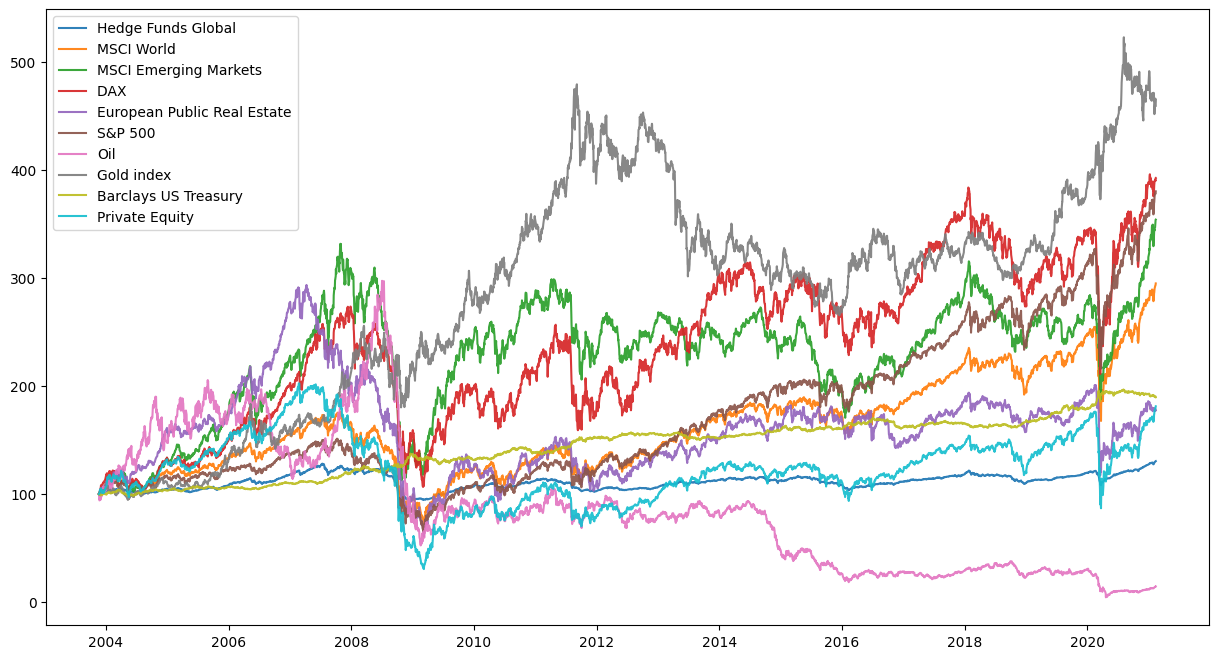

In [110]:
############# Line plot of index prices, background colored by regime ########################

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots( figsize=(15,8) )

#Loop through all indices
for factor_price in df.loc[:, first_asset:last_asset].columns:
    plt.plot(df.index , df[factor_price],
                label=factor_price, alpha = 20)

colors = ["yg","y"]

plt.legend()
plt.show()

In [111]:
##### Correlation plot between assets ######

<AxesSubplot:>

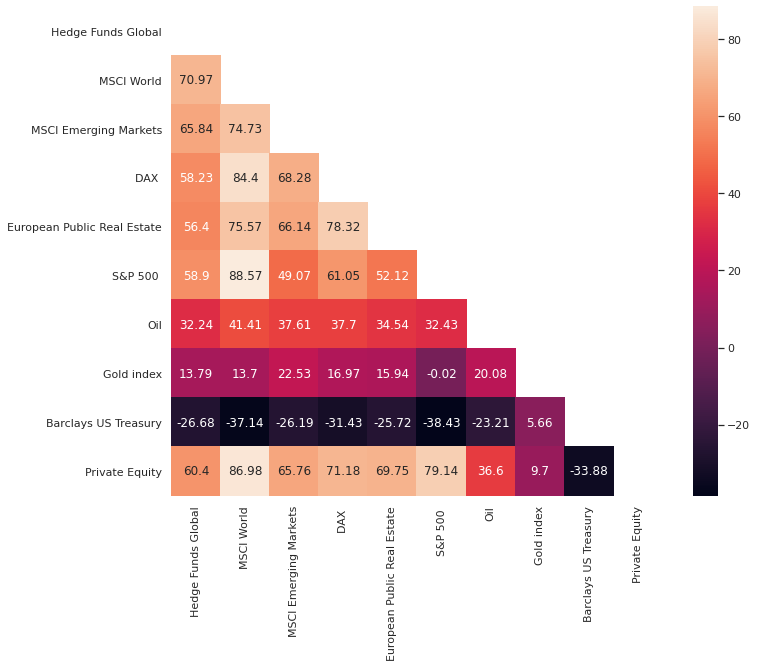

In [112]:
%matplotlib inline
import seaborn as sns
sns.set(style="white")


# Compute the correlation matrix
corr = (df_excess.loc[:, first_asset:last_asset].corr() * 100).round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, fmt="2g")

# Calculate tangency portfolios and draw frontier
Annualization formulas:
$$ \mu_{annual} = (1 + \mu_{daily})^{252} - 1 $$
$$ \sigma_{annual} = \sigma_{daily} * \sqrt{252} $$
$$ \Sigma_{annual} = \Sigma_{daily} * 252 $$

In [126]:
def mean_var(df, analytical_tan = False, dynamic=True):
    '''
    Outputs the following variables:
    weight_state, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C
    '''
    df = df.copy() #So nothing is overwritten
    
    #Number of weights to use when drawing the frontier
    weights = np.linspace(-8,8, 1000)
    
    # Number of assets and states
    N_assets = len(df.loc[: , first_asset:last_asset].columns)
    N_states = len(df["states"].unique())
    
    # Empty arrays used to store information
    weight_state = np.zeros(shape = (N_states, N_assets))
    mu = np.zeros(shape = (N_states, N_assets))  # As many rows as states and as many columns as assets
    std = np.zeros(shape = (N_states, N_assets))
    mu_tan = np.array([])
    std_tan = np.array([])
    mu_mv = np.array([])
    std_mv = np.array([])
    
    mu_C = np.zeros(shape = (N_states, len(weights)) )
    std_C = np.zeros(shape = (N_states, len(weights)) )
    
    # If static, all states are zero, and hence it does not groupby anything
    if dynamic == False:
        df["states"] = 0 
    
    for i,(state,data) in enumerate(df.groupby(by="states")):
        #Slice dataframe to only include risky assets
        data = data.loc[:,first_asset:last_asset] # Only include factor returns
        mu[i] = (1 + data.mean())**252 - 1   # Convert from daily to annualized returns
        std[i] = data.std() * np.sqrt(252) # Annualize daily standard deviations
        Sigma = (data.corr() * np.outer(std[i], std[i])).to_numpy()  #data.cov() * 252
        Sigma_inv = np.linalg.inv(Sigma)
        corr = data.corr()

        print("Average return for state", i)
        display(pd.DataFrame(mu[i], index = df_excess.loc[:, first_asset:last_asset].columns, columns = ['State {}'.format(i)]).round(4))

        print("Standard deviation for state", i)
        display(pd.DataFrame(std[i], index = df_excess.loc[:, first_asset:last_asset].columns, columns = ['State {}'.format(i)]).round(4))


        print("Correlation matrix")
        display(pd.DataFrame(corr, index = df_excess.loc[:, first_asset:last_asset].columns, columns = df_excess.loc[:, first_asset:last_asset].columns).round(4))
        ones = np.ones(len(mu[i]))
        
        ### Compute Tangency portfolio #############
        
        #### NUMERICAL SOLUTION TO TANGENCY
        def target_fun(w):
            return  -(w.T.dot(mu[i]) / np.sqrt(w.T.dot(Sigma).dot(w)) )  #Maximize this

        cons = ({"type":"eq", "fun":lambda w: np.sum(w)-1}, #weights, sum to 1
               {"type":"ineq", "fun": lambda w: w}) 

        start_val = mu[i]/sum(mu[i])

        w_tan = opt.minimize(target_fun, x0=start_val,constraints=cons, options = {"disp":False,"maxiter":10000000}, tol=0.0000000000000000000001).x

        if analytical_tan:
            w_tan = (Sigma_inv.dot(mu[i]) ) / (ones.T.dot(Sigma_inv).dot(mu[i]))
            
        weight_state[i] = w_tan

        mu_tan = np.append(mu_tan , mu[i].dot(w_tan) )
        std_tan = np.append(std_tan , np.sqrt( w_tan.T.dot(Sigma).dot(w_tan) ) )
        print("Tangency portfolio mean for state {} = {}".format(state, mu_tan))
        print("Minimum variance portfolio mean for state {} = {}".format(state, std_tan))
        
        
        
        
        #### Compute Minimum-Variance Portfolio #################
        def mv_fun(w):
            return  w.T.dot(Sigma).dot(w)  #Minimize this

        cons = ({"type":"eq", "fun":lambda w: np.sum(w)-1}, #weights, sum to 1
               {"type":"ineq", "fun": lambda w: w}) 

        start_val = mu[i]/sum(mu[i])

        w_mv = opt.minimize(mv_fun, x0=start_val,constraints=cons, options = {"disp":False,"maxiter":10000000}, tol=0.0000000000000000000001).x

        #display(pd.DataFrame(np.vstack([w_tan, w_mv]), index = data.loc[:,first_asset:last_asset].columns, columns = ['Tan weights', 'Min Var weights']))

        if analytical_tan:
            w_mv = Sigma_inv.dot(ones) / (ones.dot(Sigma_inv).dot(ones)) ## OBS! NO RISK-FREE ASSET CURRENTLY      

        mu_mv = np.append(mu_mv , mu[i].dot(w_mv) )
        std_mv = np.append(std_mv , np.sqrt( w_mv.T.dot(Sigma).dot(w_mv) ) )

State =  0
mu tan =  0.13227249468226343
std tan =  0.0631693514017393
mu mv =  0.019714473003829235
std mv =  0.024387328686578
State =  1
mu tan =  -1.0896970184937018
std tan =  0.591585790637783
mu mv =  -0.0018011899549297693
std mv =  0.024051635354433658


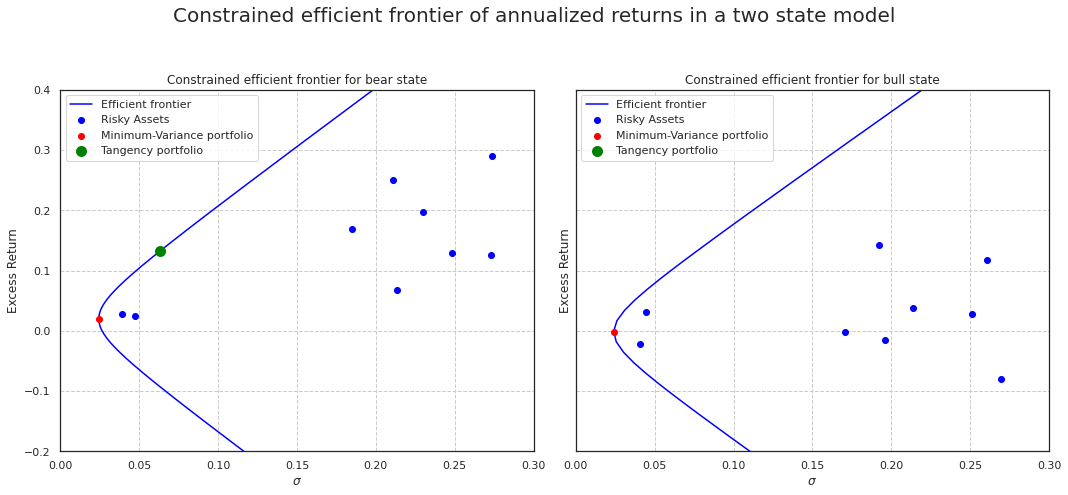

In [131]:
# Create a 2x2 grid to plot in:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7), sharey = True)
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#ax1 = plt.subplot2grid((1,2), (0,0))
#ax2 = plt.subplot2grid((1,2), (0,1))


for i,axi in enumerate([ax1, ax2]):

    # plots
    axi.plot(std_C[i],mu_C[i], color="blue", label="Efficient frontier")
    #plt.plot(std_CML,mu_CML, color="green",linestyle="dotted", label="CML")

    #Scatter
    print("State = ", i)
    print("mu tan = ", mu_tan[i])
    print("std tan = ", std_tan[i])

    print("mu mv = ", mu_mv[i])
    print("std mv = ", std_mv[i])

    axi.scatter(std[i], mu[i], color="blue", zorder=5, label="Risky Assets")
    axi.scatter(std_mv[i], mu_mv[i], color="red", zorder=5, label="Minimum-Variance portfolio")
    axi.scatter(std_tan[i] , mu_tan[i], color="green", zorder=5, label="Tangency portfolio",lw=5)
    #axi.scatter(0, rf, color = "green", label="risk-free asset")
    #plt.scatter(std_p1,mu_p1,zorder=5,label="Port 1", lw=5)
    #plt.scatter(std_p2,mu_p2,zorder=5,label="Port 2", lw = 5)

    # labels, etc
    axi.set_xlabel('$\sigma$', size=12)
    axi.set_ylabel('Excess Return', size = 12)
    
    
    axi.set_xlim(0.0,0.3)
    axi.set_ylim(-0.2,0.4)

    axi.legend()
    axi.grid(True, linestyle="--")
    

# legend & title

ax1.set_title("Constrained efficient frontier for bear state")
ax2.set_title("Constrained efficient frontier for bull state")
ax1.text(1, 1.1, ' ', transform=ax1.transAxes, size=12, color='#777777') # Creates space for the title
fig.suptitle("Constrained efficient frontier of annualized returns in a two state model", size=20)

plt.tight_layout()
plt.show()

NameError: name 'weights' is not defined

1.0